## 🎁 모듈 로드

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

## 👏 데이터 시각화 세팅

In [2]:
%matplotlib inline
sns.set_style(style="white")
sns.set()

# (Windows OS) 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
# (MAC OS)
# plt.rcParams['font.family'] = 'AppleGothic'  
# 문자 - (마이너스) 정상 출력을 위한 코드
plt.rcParams['axes.unicode_minus'] = False
# 경고 제거
plt.rcParams.update({'figure.max_open_warning': 0})

# 😒원티드 DB 국민연금 사업장 데이터 분석
---
## 데이터 정보
* 회사 수 : 약 5,000여개
- 월별데이터 : 직원 수, 국민연금 보험료(인원 수에 대한 상한선_최대고지금액이 존재함)
- 년단위 데이터 : 매출액(천원단위)

- [참고](https://github.com/chsop/team4_wanted_onboarding/blob/main/week1/%EB%B0%95%EC%B0%AC%EC%84%9C_onboarding_week1_analysis_v1.1_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81.ipynb)
---

### 데이터 Read

In [3]:
df = pd.read_csv('company_nps_data.csv',encoding='euc-kr')

In [4]:
# 데이터 형태 확인
df.head(2)

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5


In [5]:
df.describe()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
count,9.980100e+04,9.980100e+04,99801.000000,99801.000000,9.980100e+04,99801.000000
mean,2.762982e+05,3.053589e+07,2016.967125,6.714352,9.734079e+06,37.623431
std,1.339032e+05,3.016647e+08,0.976688,3.512966,4.347256e+07,146.947194
min,6.300000e+01,-7.882176e+06,2015.000000,1.000000,0.000000e+00,0.000000
25%,1.655300e+05,1.409760e+06,2016.000000,4.000000,1.181160e+06,6.000000
50%,2.591490e+05,3.573585e+06,2017.000000,7.000000,2.332760e+06,11.000000
75%,3.826560e+05,9.582321e+06,2018.000000,10.000000,5.591860e+06,24.000000
max,5.159723e+06,1.132878e+10,2019.000000,12.000000,9.780673e+08,3133.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 6 columns):
회사ID        99801 non-null int64
연매출액        99801 non-null int64
년도          99801 non-null int64
월           99801 non-null int64
월별_연금보험료    99801 non-null int64
월별_직원수      99801 non-null int64
dtypes: int64(6)
memory usage: 4.6 MB


In [7]:
# 년도별 데이터 확인 : 2015년 ~ 2019년
# 데이터의 특이점 : 2015년도와 2019년도 데이터가 현저히 적음
df['년도'].value_counts()

2018    39872
2016    37685
2017    17806
2015     3586
2019      852
Name: 년도, dtype: int64

In [8]:
# 기업별 데이터 수량 확인
len(set(df['회사ID']))

5000

---
### 데이터 전처리

- 데이터 추가
 * '년도'와 '월' 데이터를 활용하여 시계열데이터(datetime) 추가
- 이상치 제거
 * 연매출액이 0보다 낮은 경우
 * 월별직원수가 0명인 경우

In [9]:
# 데이터 추가(datetime)
df["년월"] = pd.to_datetime(df['년도'].astype(str) + df["월"].astype(str), format='%Y%m')
df = df.sort_values(by=["회사ID", "년월"])

In [10]:
# 이상치 제거
# 이상치 제거를 통해 2개 기업에 대한 데이터 삭제
df = df.drop(index=df.query('연매출액 < 0').index)
df = df.drop(index=df.query('월별_직원수 == 0').index)

In [11]:
# 고유 회사 ID 갯수 확인
len(set(df['회사ID']))
# df.drop_duplicates('회사ID')

4998

In [12]:
# 고유 회사ID 확인
unique = df["회사ID"].unique()
unique

array([     63,      95,     102, ..., 2693684, 3312354, 5159723],
      dtype=int64)

In [13]:
# 비어있는 신규 데이터 프레임 생성
column_names = ["회사ID",	"연매출액", "년도", "월", "월별_연금보험료", "월별_직원수", "년월", "월별_직원수_변동률"]
new_df = pd.DataFrame()
new_df = new_df.reindex(columns=column_names)

In [14]:
# 월별 직원수 변동률 column 추가
for i in unique:
    company = df[df["회사ID"] == i]
    roc = company["월별_직원수"].pct_change().round(2)
    company.insert(len(company.columns), "월별_직원수_변동률", roc)
    new_df = new_df.append(company, sort=False)

In [15]:
# 결측치 처리 : NaN to 0
new_df = new_df.fillna(0)

In [16]:
new_df.head()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,년월,월별_직원수_변동률
33039,63.0,1.132878e+10,2018.0,1.0,403119840.0,1006.0,2018-01-01,0.00
74251,63.0,1.132878e+10,2018.0,2.0,406770960.0,1018.0,2018-02-01,0.01
80947,63.0,1.132878e+10,2018.0,3.0,404826240.0,1013.0,2018-03-01,-0.00
80770,63.0,1.132878e+10,2018.0,4.0,404211800.0,1012.0,2018-04-01,-0.00
28110,63.0,1.132878e+10,2018.0,5.0,400339640.0,1002.0,2018-05-01,-0.01


In [17]:
# 데이터 형변환 float64 > int64
columns = ['회사ID', '연매출액', '년도', '월', '월별_연금보험료', '월별_직원수']
for i in columns:
    new_df[i] = new_df[i].astype('int64')

In [18]:
# 급여관련 데이터 추가
# 대한민국 연금보험 비율은 9%로 0.09
new_df['월별_월급총합'] = (new_df['월별_연금보험료'] / 0.09).round(2)
new_df['월별_월급평균'] = (new_df['월별_월급총합'] / df['월별_직원수']).round(2)

## ✔데이터 통계
- 4998개 기업의 2015년~2019년까지의 데이터(사업시작 기간은 기업별로 상이)
 * 최초 5000개 기업이었으나, 전처리 과정 중 이상치 제거를 진행함
---

- 최대 연매출액 :  금11,328,779,396,000원(금일십일조삼천이백팔십칠억칠천구백삼십구만육천원)
- 최대 월별 연금보험료 :  금978,067,260원(금구억칠천팔백육만칠천이백육십원)
- 최대 월별 직원수 :  3,133명


- 평균 연매출액 :  금30,544,049,000원(금삼백오억사천사백사만구천원)
- 평균 월별 연금보험료 :  금9,736,289원(금구백칠십삼만육천이백팔십구원)
- 평균 월별 직원수 : 약 38명


- 최소 연매출액 :  금300,000원(금삼십만원)
- 최소 월별 연금보험료 :  금90,000원(금구만원)
- 최소 월별 직원수 :  3명


In [19]:
new_df.head()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,년월,월별_직원수_변동률,월별_월급총합,월별_월급평균
33039,63,11328779396,2018,1,403119840,1006,2018-01-01,0.00,4.479109e+09,4452394.96
74251,63,11328779396,2018,2,406770960,1018,2018-02-01,0.01,4.519677e+09,4439761.62
80947,63,11328779396,2018,3,404826240,1013,2018-03-01,-0.00,4.498069e+09,4440344.85
80770,63,11328779396,2018,4,404211800,1012,2018-04-01,-0.00,4.491242e+09,4437986.39
28110,63,11328779396,2018,5,400339640,1002,2018-05-01,-0.01,4.448218e+09,4439339.54


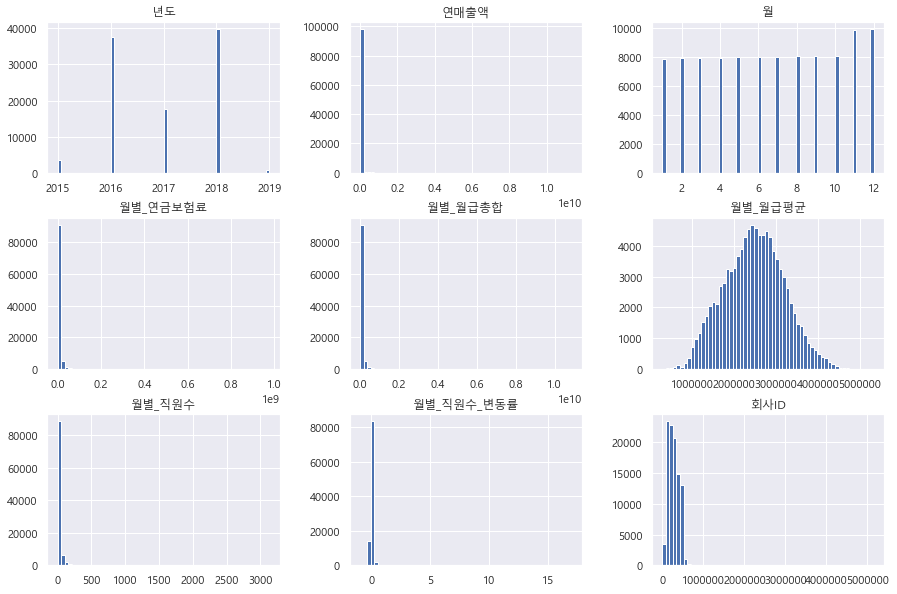

In [20]:
# 데이터 분포 시각화
# 현재의 데이터로 분포를 시각화하게 되면 기업별 분포를 확인 할 수 없음
new_df.hist(bins=60,figsize=(15,10))
plt.show()

In [21]:
# 기업별 데이터 분포를 확인하기 위해 회사ID를 기준으로 평균값 확인
group_id = new_df.groupby('회사ID').mean().round(1)

In [22]:
# 기업데이터 갯수확인
len(group_id.index)

4998

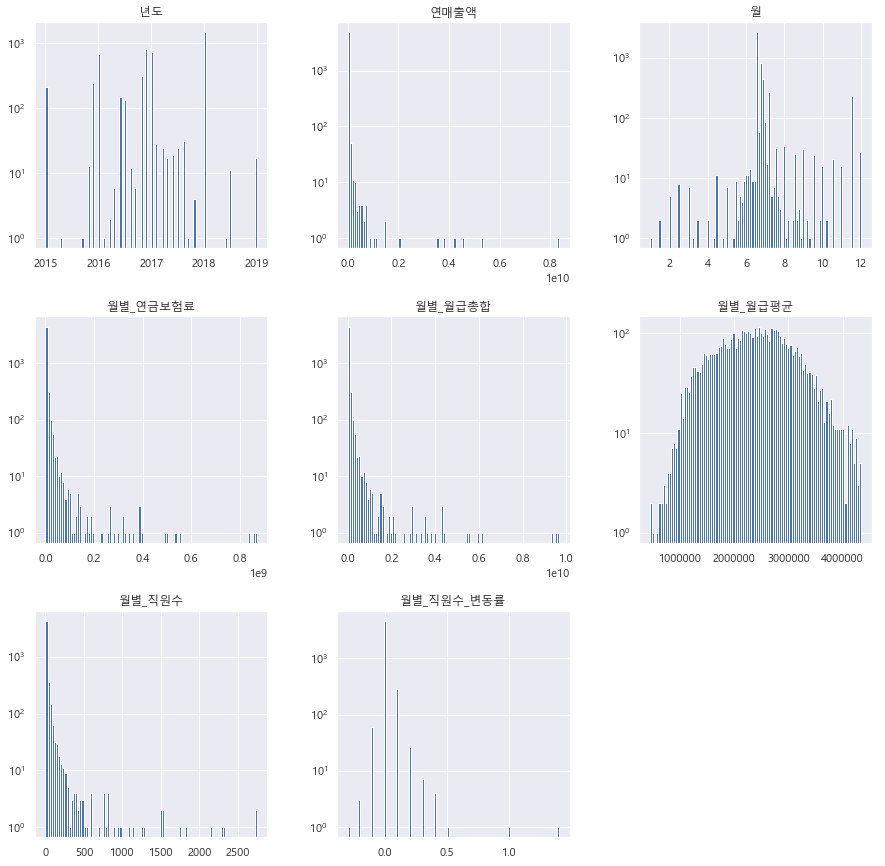

In [94]:
# 기업별 평균데이터 시각화
# 정규분포를 띄는 column은 월별_월급평균
group_id.hist(bins=100, figsize=(15,15), log=True)
plt.show()
# group_id.hist(bins=100, column=['평균_연봉'], figsize=(8,7))
# group_id.hist(bins=100, column=['연매출액', '월별_직원수_변동률'],figsize=(15,7), log=True)

In [24]:
# 참고 : https://blog.sap-press.com/data-preparation-in-sap-normalization-and-binning
# # 데이터 이산화
# n_bins = 5
# bin_labels = list(range(1, n_bins+1))

# for i in ['월별_월급평균']:
#     new_column = i+"bin"
#     new_df.loc[:,new_column] = pd.cut(new_df[i], n_bins, labels=bin_labels)

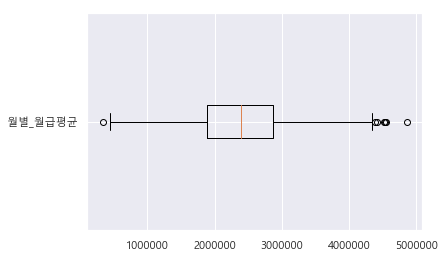

In [25]:
# boxplot을 활용한 월별_월급평균 column의 분포 확인
# 이상치가 확인되었음
fig, ax = plt.subplots()

ax.boxplot([group_id['월별_월급평균']], vert=0)
plt.yticks([1],["월별_월급평균"])
plt.show()

In [26]:
# 참고링크 : https://wikidocs.net/83562
# 정규분포를 벗어나는 값 제거
# 사분위수범위(IQR = interquartile Range) 산출
# 1사분위수(25percentile, lower quartile)
quartile_1 = group_id['월별_월급평균'].quantile(0.25)

# 3사분위수(75percentile, upper quartile)
quartile_3 = group_id['월별_월급평균'].quantile(0.75) 
IQR = quartile_3 - quartile_1
search_df = group_id[(group_id['월별_월급평균'] < (quartile_1 - 1.5 * IQR)) | (group_id['월별_월급평균'] > (quartile_3 + 1.5 * IQR))]
group_id = group_id.drop(search_df.index, axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4991 entries, 102 to 5159723
Data columns (total 8 columns):
연매출액          4991 non-null float64
년도            4991 non-null float64
월             4991 non-null float64
월별_연금보험료      4991 non-null float64
월별_직원수        4991 non-null float64
월별_직원수_변동률    4991 non-null float64
월별_월급총합       4991 non-null float64
월별_월급평균       4991 non-null float64
dtypes: float64(8)
memory usage: 350.9 KB


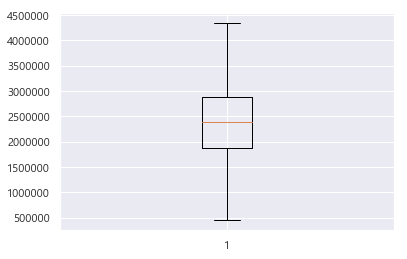

In [27]:
# 이상치 제거를 통해 7개의 데이터 삭제
group_id.info()
plt.boxplot(group_id['월별_월급평균'])
plt.show()

In [28]:
# 국내 유니콘 기업 현황 데이터
# 해당 데이터로 유추할 수 있는 내용은 등재시점 이전 기간동안 상승세를 보일것이라고 생각할 수 있음

k_unicorn_list = pd.read_csv('k_unicorn_list.csv',encoding='utf-8')
k_unicorn_list['평균월급'] = (k_unicorn_list['평균연봉']/12).round(1)
k_unicorn_list

,기업명,창업연도(년),창업연도(월),등재시점(년),등재시점(월),주요브랜드,업종,직원수,평균연봉,평균월급
0,쿠팡,2010,8,2014,5,쿠팡,온라인 쇼핑,6372,38610000,3217500.0
1,크래프톤,2007,3,2018,8,"테라, 배틀그라운드",온라인 게임,730,56990000,4749166.7
2,비바리퍼블리카,2013,4,2018,12,토스,핀테크,717,52997000,4416416.7
3,위메프,2010,5,2015,9,위메프,온라인 쇼핑,1500,40250000,3354166.7
4,무신사,2012,6,2019,11,무신사,패션커머스,510,32700000,2725000.0
5,지피클럽,2003,9,2018,10,JM솔루션 강블리라이프,화장품,170,33370000,2780833.3
6,엘앤피코스메틱,2009,4,2016,1,메디힐,화장품,177,44000000,3666666.7
7,에이프로젠,2000,4,2019,5,GS071,바이오,115,42090000,3507500.0
8,야놀자,2007,2,2019,6,야놀자,여가 플랫폼,1000,47860000,3988333.3
9,쏘카,2011,10,2020,10,쏘카,차량공유,335,43270000,3605833.3


In [53]:
# 현재 5000개 기업에 대한 2015 ~ 2019년도 데이터를 보유하고 있기 때문에 등재시점을 필터링함
# 2015 ~ 2019년도 사이에 등재된 기업은 총 4개이나, 2016년 에 등재된 기업은 2015년 데이터가 부족하여 제외
# 우선적으로 2018년도에 등재된 3개 기업에 초점을 맞추고 데이터를 확인
filterd_k_unicorn = k_unicorn_list[(k_unicorn_list['등재시점(년)'] > 2015) & (k_unicorn_list['등재시점(년)'] < 2019)]
display(filterd_k_unicorn)

,기업명,창업연도(년),창업연도(월),등재시점(년),등재시점(월),주요브랜드,업종,직원수,평균연봉,평균월급
1,크래프톤,2007,3,2018,8,"테라, 배틀그라운드",온라인 게임,730,56990000,4749166.7
2,비바리퍼블리카,2013,4,2018,12,토스,핀테크,717,52997000,4416416.7
5,지피클럽,2003,9,2018,10,JM솔루션 강블리라이프,화장품,170,33370000,2780833.3
6,엘앤피코스메틱,2009,4,2016,1,메디힐,화장품,177,44000000,3666666.7


In [30]:
# 기존 데이터에서 회사ID를 기준으로 년도 평균월급 데이터를 추출
year_extract = new_df.groupby(['회사ID', '년도'])['월별_월급평균'].mean().unstack()

In [31]:
# 추출한 년도별 평균월급 데이터의 2016~2018년도 데이터를 슬라이싱 한 뒤 결측치를 제거한 후 인덱스를 추출함
year_index_extract = year_extract.loc[:,2016:2018].dropna().index
year_index_extract

Int64Index([ 14271,  59533, 122968, 123082, 123219, 123235, 123464, 123649,
            123882, 124181,
            ...
            509060, 510329, 511468, 512107, 512308, 513218, 514152, 514934,
            515264, 516653],
           dtype='int64', name='회사ID', length=1156)

In [32]:
# 2016 ~ 2018년도 데이터를 확인하기 위해 회사id를 기준으로 인덱싱
# 1156개의 데이터 확인
group_id_20162018 = group_id.loc[year_index_extract]

In [36]:
group_id_20162018.head()
# group_id_20162018[group_id_20162018['월별_월급평균'] > 3500000]

,연매출액,년도,월,월별_연금보험료,월별_직원수,월별_직원수_변동률,월별_월급총합,월별_월급평균
회사ID,,,,,,,,
14271,6453748.8,2017.4,6.7,4050308.8,18.3,0.0,45003431.1,2474324.8
59533,160776.5,2016.9,6.8,500620.5,5.5,-0.0,5562450.3,1011076.1
122968,30823265.4,2016.9,6.8,15630783.7,72.2,-0.0,173675374.3,2406525.7
123082,6468566.0,2017.0,6.5,3972687.2,25.2,-0.0,44140969.1,1765512.8
123219,3796056.3,2017.0,6.5,2856206.7,15.5,-0.0,31735629.6,2068535.4


In [52]:
# 필터링한 기업별 최소 값
id_min = new_df.groupby('회사ID').min()
id_min_lst = id_min.loc[year_index_extract]

# 필터링한 기업별 평균 월급
id_mean = new_df.groupby('회사ID').mean()
id_mean_lst = id_mean.loc[year_index_extract]

# 필터링한 기업별 최대 월급
id_max = new_df.groupby('회사ID').max()
id_max_lst = id_max.loc[year_index_extract]

id_min_lst.head()

,연매출액,년도,월,월별_연금보험료,월별_직원수,년월,월별_직원수_변동률,월별_월급총합,월별_월급평균
회사ID,,,,,,,,,
14271,1199495,2015,1,2571840,11,2015-11-01,-0.12,2.857600e+07,2263444.44
59533,124299,2015,1,365020,4,2015-11-01,-0.33,4.055778e+06,1000977.78
122968,26858719,2015,1,13063400,62,2015-11-01,-0.18,1.451489e+08,2237216.80
123082,6001508,2016,1,3454000,20,2016-01-01,-0.14,3.837778e+07,1589711.11
123219,3699796,2016,1,2552860,11,2016-01-01,-0.26,2.836511e+07,1811250.00


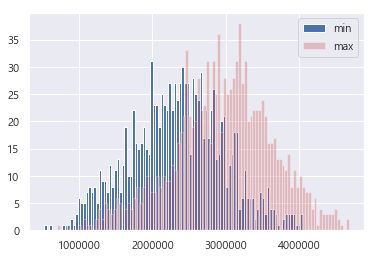

In [90]:
# 필터링한 기업별 월급평균 min-max 분포 시각화
id_min_lst['월별_월급평균'].hist(bins=100, alpha=1, label='min')
# id_mean_lst['월별_월급평균'].hist(bins=100, alpha=0.3, label='mean', color='c')
id_max_lst['월별_월급평균'].hist(bins=100, alpha=0.3, label='max', color='r')

plt.legend()

In [91]:
# 2018년도에 유니콘 기업으로 등재된 기업의 평균월급의 평균값을 산출
k_unicorn_pay_mean = filterd_k_unicorn[:3]['평균월급'].mean()
filterd_k_unicorn
k_unicorn_pay_mean

3982138.9

In [69]:
# 평균월급의 최소값이 등재된 유니콘 기업의 평균월급의 평균값보다 크거나 작은 기업으로 필터링
# 결과, 4개 기업 리스트를 확인할 수 있음
id_min_lst[id_min_lst['월별_월급평균'] >= k_unicorn_pay_mean]

,연매출액,년도,월,월별_연금보험료,월별_직원수,년월,월별_직원수_변동률,월별_월급총합,월별_월급평균
회사ID,,,,,,,,,
126831,1753200162,2015,1,213087620,581,2015-11-01,-0.01,2.367640e+09,4051762.28
137497,45234479,2016,1,15512360,42,2016-01-01,-0.04,1.723596e+08,4020500.00
294649,3447722831,2015,1,97692480,259,2015-11-01,-0.04,1.085472e+09,3998205.88
420304,60399446,2016,1,40414660,111,2016-01-01,-0.03,4.490518e+08,4038092.43


In [92]:
# 4개 기업에 대한 데이터 확인
unicorn_1 = new_df[new_df['회사ID'] == 126831]
unicorn_2 = new_df[new_df['회사ID'] == 137497]
unicorn_3 = new_df[new_df['회사ID'] == 294649]
unicorn_4 = new_df[new_df['회사ID'] == 420304]

In [261]:
unicorn_4

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,년월,월별_직원수_변동률,월별_월급총합,월별_월급평균
28877,420304,60399446,2016,1,41551360,114,2016-01-01,0.00,4.616818e+08,4049840.16
16887,420304,60399446,2016,2,40793560,112,2016-02-01,-0.02,4.532618e+08,4046980.16
4974,420304,60399446,2016,3,40793560,112,2016-03-01,0.00,4.532618e+08,4046980.16
47808,420304,60399446,2016,4,40793560,112,2016-04-01,0.00,4.532618e+08,4046980.16
54363,420304,60399446,2016,5,40414660,111,2016-05-01,-0.01,4.490518e+08,4045511.51
27274,420304,60399446,2016,6,41067400,113,2016-06-01,0.02,4.563044e+08,4038092.43
41791,420304,60399446,2016,7,44586700,117,2016-07-01,0.04,4.954078e+08,4234254.51
40331,420304,60399446,2016,8,44586700,117,2016-08-01,0.00,4.954078e+08,4234254.51
6921,420304,60399446,2016,9,44586700,117,2016-09-01,0.00,4.954078e+08,4234254.51
41995,420304,60399446,2016,10,45115880,119,2016-10-01,0.02,5.012876e+08,4212500.47


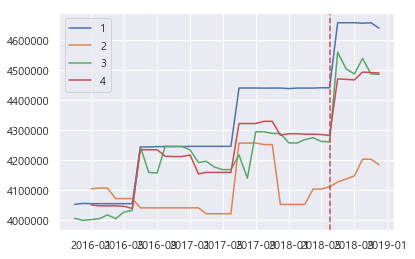

In [93]:
# 4개 기업의 월별_월급평균 데이터 시각화1
plt.plot(unicorn_1['년월'], unicorn_1['월별_월급평균'], label=1)
plt.plot(unicorn_2['년월'], unicorn_2['월별_월급평균'], label=2)
plt.plot(unicorn_3['년월'], unicorn_3['월별_월급평균'], label=3)
plt.plot(unicorn_4['년월'], unicorn_4['월별_월급평균'], label=4)
plt.axvline(x=datetime(2018, 6, 1), color='r', ls="--")
plt.legend()

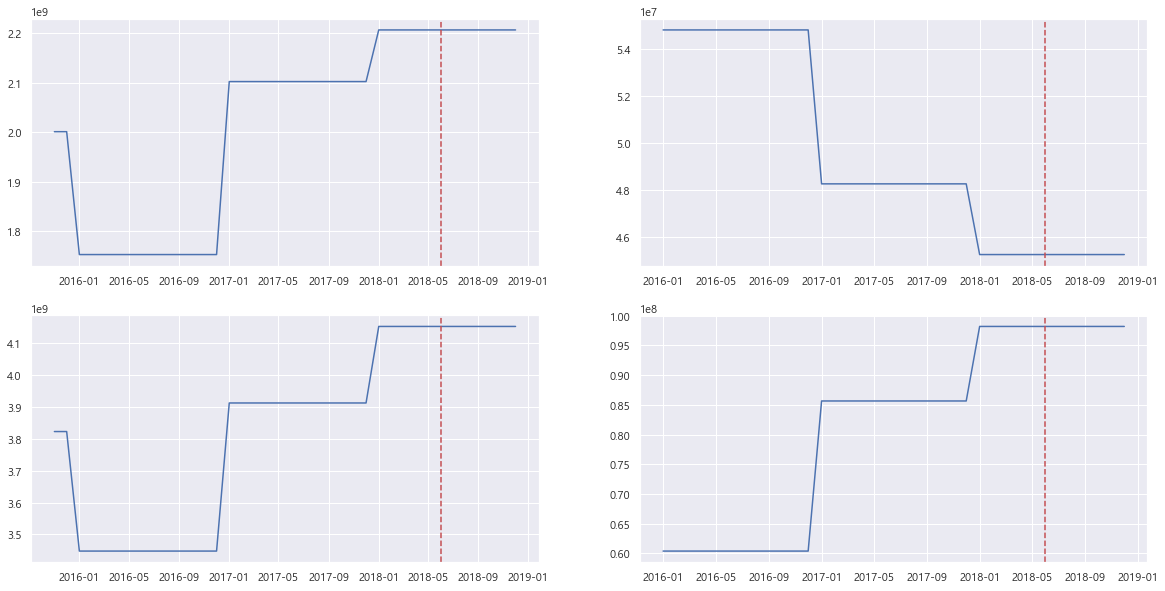

In [86]:
# 4개 기업의 월별_월급평균 데이터 시각화2
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.plot(unicorn_1['년월'], unicorn_1['연매출액'])
plt.axvline(x=datetime(2018, 6, 1), color='r', ls="--")

plt.subplot(222)
plt.plot(unicorn_2['년월'], unicorn_2['연매출액'])
plt.axvline(x=datetime(2018, 6, 1), color='r', ls="--")

plt.subplot(223)
plt.plot(unicorn_3['년월'], unicorn_3['연매출액'])
plt.axvline(x=datetime(2018, 6, 1), color='r', ls="--")

plt.subplot(224)
plt.plot(unicorn_4['년월'], unicorn_4['연매출액'])
plt.axvline(x=datetime(2018, 6, 1), color='r', ls="--")

plt.show()


In [ ]:
- 4개 기업 모두가 등재시점(2018년) 이전에 평균월급이 지속적으로 상승하는 모습을 보임
- 추가적으로, 유의미한 년도별 데이터 산출(2016~2018) 이후 정규분포를 보이는 컬럼을 스케일링 한 하여 스코어화 하는 방법